# Using states' Secretary of State data to learn about organizations


## Outline:
    1. Scrape some data and load it into Elasticsearch
    2. Visual data inspection with Kibana
    3. Query Elasticsearch for data to put into a pandas dataframe
    4. Prep the dataframe by adding new variables
    5. Make models and learn something new about companies in Rhode Island

### Before starting, make sure you have ready:
    - Elasticsearch (installed and running) (both the program & the Python package)
    - Tor (installed and running)
    - bs4, aka BeautifulSoup
    - pandas
    - pysocks isn't imported, but it must be installed

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests
import json
import random
import re
import pickle
import math
import collections
from nltk.stem import PorterStemmer
import elasticsearch.helpers
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from elasticsearch import Elasticsearch
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from scipy.stats import anderson, normaltest, boxcox

# Step 1: scrape some data

### Scraping data can be illegal! I'm not recommending you do it, just showing you how easy it is to do. If you're interested in the analysis, you can buy this full database from the Rhode Island Secretary of State for fifty bucks.


### We're using Tor just to show how to use Tor. Unless you're scraping the dark web, using Tor is pretty impractical. Tor is orders of magnitude slower than normal requests.

### The data we collect is being stored in Elasticsearch. You could keep it around in memory, but it takes a long time to scrape data, so it's better to save it to a database so you can quickly use it again in the future if need be.

In [ ]:
def get_tor_session():
    session = requests.session()
    # Set up your proxies to use Tor
    session.proxies = {'http': 'socks5://localhost:9150',
                       'https': 'socks5://localhost:9150'}
    return session

In [ ]:
def try_and_except_loop(soup, data_dict, value, prefix, value_not_text=False):
    """A short loop to keep things a little DRYer"""
    if value_not_text:
        try:
            data_dict[value] = soup.find(id=prefix + str(value)).value
        except AttributeError:
            pass
    else:
        try:
            data_dict[value] = soup.find(id=prefix + str(value)).text
        except AttributeError:
            pass

In [ ]:
# After inspecting the web page we're going to be grabbing, I got the names of the worthwhile fields:
VALUES_TO_EXTRACT = ["EntityName",
                    "EntityType",
                    "OrganisationDate", # Yes, this is misspelled in the HTML
                    "EffectiveDate",
                    "InactiveDate",
                    "PrincipleStreet",
                    "PrincipleCity",
                    "PrincipleState",
                    "PrincipleZip",
                    "PrincipleCountry",
                    "ResidentAgentFlag",
                    "ConsentFlag",
                    "ResidentAgentName",
                    "ResidentStreet",
                    "ResidentCity",
                    "ResidentState",
                    "ResidentZip",
                    "ResidentCountry"]

def parse_rhode_island_entity_summary(session):
    """When given Rhode Island's Entity Summary page, this builds a dictionary of
        all the noteworthy data on the webpage"""
    data_dict = {}
    soup = BeautifulSoup(session._content)

    # This value includes the words "Identification Number: ". Clear that useless text.
    # Also, if there is no ID number present, then there's no other information present either,
    # and there's no need to continue selecting data.
    try:
        data_dict["IDNumber"] = soup.find(id="MainContent_lblIDNumber").text[-9:]
    except AttributeError:
        return False

    for item in VALUES_TO_EXTRACT:
        try_and_except_loop(soup, data_dict, item, "MainContent_lbl")
    try_and_except_loop(soup, data_dict, "Comments", "MainContent_txt")
    try_and_except_loop(soup, data_dict, "NIACS", "MainContent_txt", value_not_text=True)

    # The length of the list of directors & officers varies by company
    d_and_o_list = []
    table = soup.find(id="MainContent_grdOfficers")
    try:
        for row in table.find_all('tr')[1:]:
            col = row.find_all('td')
            d_and_o_list += [col[0].text, col[1].text, col[2].text]
    except AttributeError:
        # Some pages don't have information on directors & officers
        pass
    data_dict['d_and_o'] = d_and_o_list

    # I have no idea if their data on stocks is meaningful, but just in case:
    try:
        stock_cols = soup.find(id="MainContent_grdStocks").tbody.tr.find_all('td')
        data_dict['stock_info'] = [stock_cols[item].text for item in range(len(stock_cols))]
    except AttributeError:
        # Some pages don't have information on stocks. Makes sense, since all the info isn't on corporations.
        pass

    return data_dict

In [2]:
es = Elasticsearch()

def create_elasticsearch_index():
    """This should only be run once: re-running it will delete any saved data!"""
    es.indices.delete(index="ri_sos", ignore=[400, 404])
    es_settings = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0
        },
        "mappings": {
            "corporate_data": {
                "properties": {
                    "OrganisationDate": {
                        "type": "date",
                        "format": "MM-dd-yyyy"
                    },
                    "EffectiveDate": {
                        "type": "date",
                        "format": "MM-dd-yyyy"
                    },
                    "InactiveDate": {
                        "type": "date",
                        "format": "MM-dd-yyyy"
                    },
                    "IDNumber": {
                        "type": "integer"
                    }
                }
            }
        }}
    es.indices.create(index="ri_sos", body=es_settings)

In [ ]:
def save_data_in_elasticsearch(returned_page):
    """Updates elasticsearch with a single row of data"""
    try:
        es.index(index="ri_sos", doc_type="corporate_data", body=json.dumps(returned_page))
    except:
        # Don't let the scraping stop in case some page has an unusual structure.
        # Instead, print out the bad data & figure out the exceptions later.
        print("Didn't save:", returned_page)

In [ ]:
def collect_rhode_island_data(start_at=0, records_to_get=1, create_index=False, random_subset_size=False, prior_records=False,
                              failed_records=[]):
    """This function ties together connecting with Tor, scraping data, and loading it into Elasticsearch.
        It returns a list of all records it unsuccessfully tried to grab."""
    URL_string = "http://ucc.state.ri.us/CorpWeb/CorpSearch/CorpSummary.aspx?FEIN="
    session = get_tor_session()
    # Since we're already using Tor, let's pretend we're accessing the web through a browser
    # instead of letting people see it's through a Python script:
    headers = {'User-agent': 'Opera/1.1.2 FCS'}

    ## If you want to confirm that you're using Tor, then see if your
    ## session's IP address matches a normal request's IP address
    # print("TOR IP address:", session.get("http://httpbin.org/ip").text)
    # print("Your normal IP address:", requests.get("http://httpbin.org/ip").text)

    # If this is your first time through, then you'll need to create an index in Elasticsearch
    if create_index:
        create_elasticsearch_index()

    # Options for random sampling of data
    if random_subset_size:
        records = random.sample(range(165000), random_subset_size)
    else:
        records = [start_at + item for item in range(records_to_get)]
    if prior_records:
        records = set(records) - set(prior_records)

    for record in records:
        corp_id = str(start_at + record)
        # The string provided should be 9 digits long, padded by prepended by 0s
        corp_id = corp_id.rjust(9, "0")

        returned_page = session.get(URL_string + str(corp_id), headers=headers)
        data_dict = parse_rhode_island_entity_summary(returned_page)
        if data_dict:
            # Value will be false if the page scraped is blank, so no need to save anything
            save_data_in_elasticsearch(data_dict)
        else:
            failed_records += [record]

        # Clear cookies to make it harder to track you between requests:
        session.cookies.clear()
    return failed_records

## Uncomment & run this if it's your first time running this script:

In [ ]:
# Now we finally start collecting some data
#### ONLY RUN THIS ONCE! OTHERWISE IT WILL DELETE YOUR INDEX, DELETING ALL OF YOUR DATA!
# failed_records = collect_rhode_island_data(start_at=0, 
#                                           records_to_get=5,
#                                           create_index=True)

## Otherwise load your previously saved list of failed records:

In [ ]:
# Load your list of pickled failed records:

#with open('failed_records', 'rb') as fp:
#    failed_records = pickle.load(fp)

### Rhode Island has about 165,000 companies that follow the expected URL pattern. At 1 request/second, that's ~46 hours of scraping to get everything. We could speed up the process by making bulk entries into Elasticsearch rather than making individual entries, by making multiple requests at a time, or using normal requests instead of Tor, but we don't want to overwhelm the server. Always be nice to whoever has to maintain the servers you're talking to. Scraping slowly is nice.

### We don't need the full database to do some analysis. Instead of scraping everything, let's randomly pull some samples and study that subset.

In [ ]:
failed_records = collect_rhode_island_data(start_at=0,
                                           random_subset_size=5,
                                           failed_records=failed_records)

In [ ]:
# Pull prior_records from Elasticsearch so you don't pull them again:
def get_prior_records(failed_records):
    """Return a list of all the IDNumbers saved in Elasticsearch, including any failed_records you want to exclude"""
    records_search = elasticsearch.helpers.scan(
        es, 
        query={"query": {"match_all": {}}, "_source":["IDNumber"]},
        index="ri_sos",
        doc_type="corporate_data")

    # Return these records, plus the failed_records we already knew about
    return [item['_source']['IDNumber'] for item in list(records_search)] + failed_records

In [ ]:
# Scrape some new records, but don't repeat anything that's already saved in Elasticsearch:
failed_records = collect_rhode_island_data(start_at=0,
                                           random_subset_size=10,
                                           prior_records=get_prior_records(failed_records),
                                           failed_records=failed_records)

### Re-run the above command whenever you want to add more new data to Elasticsearch. Remember to be nice about it! Don't do it in the middle of a workday, ask for 10,000 records at once, etc. Or don't do it at all because of its questionable legality. You can order the entire DB for $50 from their office.

# Step 2: inspect your data in Kibana

In [ ]:
# Kibana gives you those pretty graphs in iframes. They're nice and easy to put on a web page.
# I'll add them if I ever make a blog post about this.

## It's strange that there are records with InactiveDates from 1820 in my data. 
### Visual inspection of the data in Kibana shows that data with an InactiveDate is incredibly sparse until around 1985. I'm going to assume that Rhode Island didn't worry about putting in many inactive corporations into their corporate database when they created it. 
### It seems reasonable to exclude companies founded before 1984. However, that also puts a ceiling on the life expectancies of companies in my data. Whether they should be excluded or not depends on how you want to use this analysis. I'm going to leave them for now and view this as a study of companies that existed between 1985 and today, regardless of when they were founded.

# Step 3: load your data into pandas and inspect it more carefully

In [3]:
# Let's load the database into pandas. Our actual analysis later will only use samples that
# have an InactiveDate, so only request data with that data. We'd also want to filter out newer
# companies to only work with companies that have had a long time to go out of business, but
# reviewing our data in Kibana shows that our newest data is in 2007, implying that newer
# companies have a different URL pattern than older companies. No need to filter based on date organized.

data_to_load = elasticsearch.helpers.scan(
                    es,
                    query={"query": {"exists": {"field": "InactiveDate"}}},
                    index="ri_sos",
                    doc_type="corporate_data")

# Initialize a double ended queue
output_all = collections.deque()
# Extend deque with iterator
output_all.extend(data_to_load)
only_data = [item["_source"] for item in output_all]

df = json_normalize(only_data)
print(df.shape)

(32480, 23)


# Step 4: prepare the data
## Lifespan of businesses: a quick inspection
### Our goal is to see how long businesses in different industries stay in business. We don't have a variable for length in business yet, so let's make it.

In [4]:
# How many companies have out-of-business dates?
df = df.assign(time_in_business=pd.Series(np.nan))

# Convert date columns to the date format
df['InactiveDate'] = pd.to_datetime(df['InactiveDate']).dt.date
df['OrganisationDate'] = pd.to_datetime(df['OrganisationDate']).dt.date

# Add the variable 'time_in_business' when we can calculate it:
df.loc[df['InactiveDate'] != np.nan, 'time_in_business'] = (df['InactiveDate'] - df['OrganisationDate']).dt.days

# We're trying to predict time_in_business, so let's remove all rows without a value for that
df = df[df.time_in_business.notnull()]
print("Returned shape:", df.shape)
print("")

print(df.time_in_business.describe())

Returned shape: (32462, 24)

count    32462.000000
mean      3514.399174
std       4116.308415
min       -393.000000
25%       1030.000000
50%       2119.000000
75%       4303.000000
max      61626.000000
Name: time_in_business, dtype: float64


### How to deal with negative values for time_in_business if you have them in your data

In [5]:
# How is there a negative value for time_in_business? Your sample may not have one, but mine did.

weird_row = df.loc[df.time_in_business == df.time_in_business.min()]
print(weird_row.IDNumber)

22741    000002273
Name: IDNumber, dtype: object


In [6]:
# On manual inspection, Rhode Island's records do in fact show at least one company as having been 
# dissolved before it was created. That's very strange. 
# Manually inspect & delete any records with negative lifespans.

weird_rows = df.loc[df.time_in_business < 0]
print(weird_rows.IDNumber)

2236     000000417
22067    000000417
22741    000002273
Name: IDNumber, dtype: object


In [7]:
# Don't run this cell without inspecting your own data!
df.drop(df[df.time_in_business < 1].index, inplace=True)
print("Resulting shape:", df.shape)

Resulting shape: (32455, 24)


In [8]:
# The max time_in_business number I have is 61626 days, or 169 years! Does Rhode Island really have that much data?
too_long = df.loc[df.time_in_business > 36500]
print(too_long[["IDNumber", "time_in_business"]][:10])

# I manually inspected these in my data, and they were legit. An old bank, an old cemetery, lots of churches, etc.

       IDNumber  time_in_business
118   000025265           36599.0
406   000031053           50390.0
5118  000026992           46649.0
6009  000029417           43200.0
6415  000030582           48010.0
6501  000022645           39415.0
6867  000031867           38379.0
7967  000026290           37750.0
8102  000001992           61626.0
8419  000027238           45379.0


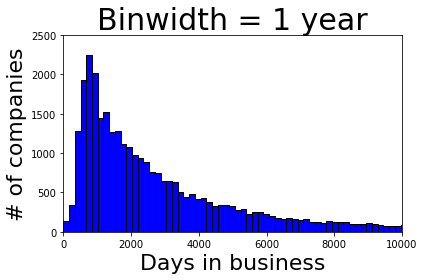

In [9]:
# Let's graph the distribution to see what it looks like
plt.hist(df.time_in_business, bins = 365,
         color = 'blue', edgecolor = 'black')
plt.axis([0, 10000, 0, df.shape[0] / 13])
plt.title('Binwidth = 1 year', size = 30)
plt.xlabel('Days in business', size = 22)
plt.ylabel('# of companies', size= 22)

plt.tight_layout()
plt.show()

count    32455.000000
mean         7.682856
std          0.985654
min          0.000000
25%          6.937314
50%          7.659171
75%          8.367068
max         11.028839
Name: log_tib, dtype: float64


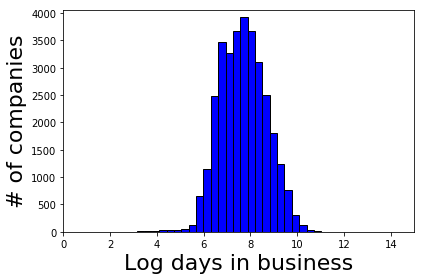

In [10]:
# This variable is much more appropriate to work with as a log
first_tib = df[["time_in_business", "IDNumber"]].copy()
first_tib["log_tib"] = np.log(first_tib.time_in_business)
print(first_tib.log_tib.describe())

# Graph it:
plt.hist(first_tib.log_tib, bins = 35,
         color = 'blue', edgecolor = 'black')
plt.axis([0, 15, 0, df.shape[0] / 8])
plt.xlabel('Log days in business', size = 22)
plt.ylabel('# of companies', size= 22)

plt.tight_layout()
plt.show()

In [11]:
# This looks like a normal/Gaussian distrubtion to me. Let's make sure:
print(anderson(first_tib.log_tib))
print("")

stat, p = normaltest(first_tib.log_tib)
print(stat, p)
if p > 0.05:
    print('We can assume a normal distribution (fail to reject H0)')
else:
    print("This doesn't look like a normal distribution (reject H0)")

AndersonResult(statistic=36.75036083165469, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

87.57501944588827 9.623347113283342e-20
This doesn't look like a normal distribution (reject H0)


# What can we do about our variable of interest failing its normality tests?

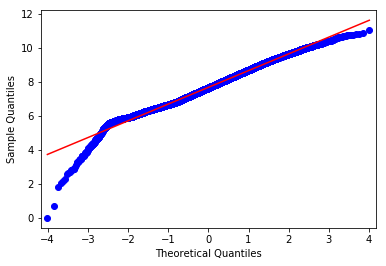

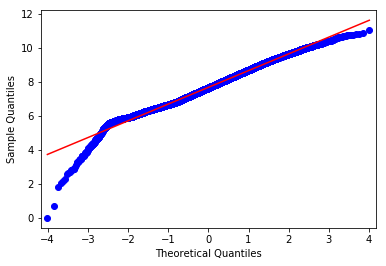

In [12]:
# Why isn't this normal? Let's make a quantile-quantile plot to inspect further:
from statsmodels.graphics.gofplots import qqplot
qqplot(first_tib.log_tib, line='s')

In [13]:
# There are problems in the tails. That's not unexpected. Some businesses seem to shut down almost immediately,
# and taking the log of small numbers gives small numbers. For reference, the log of half a year in days ~= 5.2.
# There are a reasonable number of corporations that closed that quickly. 
new_df = first_tib.drop(df[first_tib.log_tib > 5].index)
print("Companies with log_tib < 5:    ", new_df.shape[0])

Companies with log_tib < 5:     126


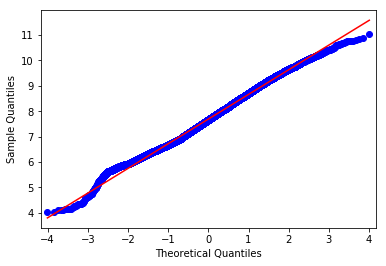

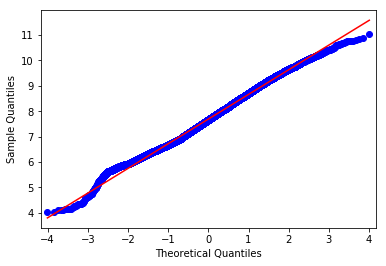

In [14]:
# What if we only look at data where log_tib > 4?
smaller_tib_df = first_tib.drop(df[first_tib.log_tib < 4].index)
qqplot(smaller_tib_df.log_tib, line='s')

In [15]:
# Normality tests on our adjusted DF:
print(anderson(smaller_tib_df.log_tib))
print("")

stat, p = normaltest(smaller_tib_df.log_tib)
print(stat, p)
if p > 0.05:
    print('We can assume a normal distribution (fail to reject H0)')
else:
    print("This doesn't look like a normal distribution (reject H0)")

AndersonResult(statistic=45.01683117806169, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

262.4525130625439 1.0213178154947688e-57
This doesn't look like a normal distribution (reject H0)


### Oof. Dropping those values made us fail the normality tests by an even larger margin.

AndersonResult(statistic=38.81120835130059, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

53.52792844481411 2.3798962481562054e-12
This doesn't look like a normal distribution (reject H0)


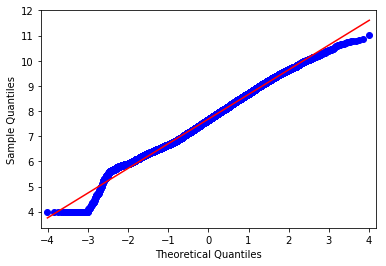

In [16]:
# What if, instead of dropping companies that failed super quickly, we set their value to some floor value?
# For reference, log(55) ~= 4. We're setting a floor equal to about 2 months in business.
first_tib['masked_tib'] = first_tib['log_tib']
first_tib.loc[first_tib.log_tib < 4, 'masked_tib'] = 4

# Print the Q-Q plot
qqplot(first_tib.masked_tib, line='s')

# Run the normality tests
print(anderson(first_tib.masked_tib))
print("")

stat, p = normaltest(first_tib.masked_tib)
print(stat, p)
if p > 0.05:
    print('We can assume a normal distribution (fail to reject H0)')
else:
    print("This doesn't look like a normal distribution (reject H0)")

### Setting a lower limit for log(time_in_business) made things better, but not very meaningfully.
### Let's see if Box-Cox can do any better.

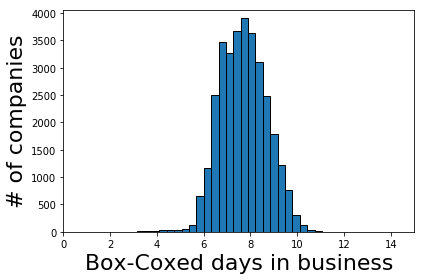

In [17]:
first_tib['bc_tib'] = boxcox(df.time_in_business)[0]

# Graph it:
plt.hist(first_tib.bc_tib, bins = 35, edgecolor = 'black')
plt.axis([0, 15, 0, df.shape[0] / 8])
plt.xlabel('Box-Coxed days in business', size = 22)
plt.ylabel('# of companies', size= 22)

plt.tight_layout()
plt.show()

In [18]:
# Normality tests again:
print(anderson(first_tib.bc_tib))
print("")

stat, p = normaltest(first_tib.bc_tib)
print(stat, p)
if p > 0.05:
    print('We can assume a normal distribution (fail to reject H0)')
else:
    print("This doesn't look like a normal distribution (reject H0)")

AndersonResult(statistic=36.91422027554654, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

85.97985345012555 2.1365450073894404e-19
This doesn't look like a normal distribution (reject H0)


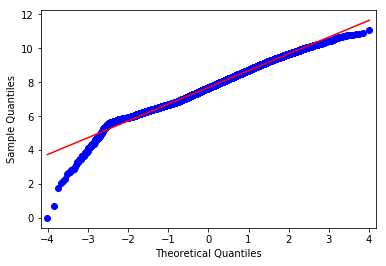

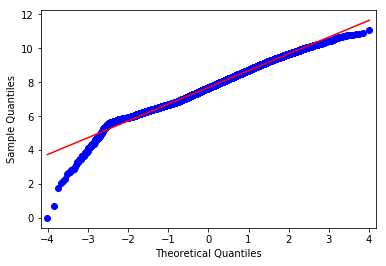

In [19]:
qqplot(first_tib.bc_tib, line='s')

### Our data with a floor did better than Box-Cox, but none of our adjustmented distributions are technically Gaussian. However, visually they all appear so close to Gaussian that we're going to assume that we're close enough and won't violate any normality assumptions for parametric methods.

In [20]:
# Since we have to pick 1, let's use our 
df["log_time_in_business"] = first_tib['masked_tib']

#### We should inspect our other variables further, especially since we found some weird values in time_in_business. It's also worth inspecting whether we should log other variables, like the number of directors & officers. However, this is more a proof-of-concept, so I'll worry about that later.

## Next, let's look at our explanatory variables

### Let's start by seeing what types of companies we have lots of data on.

In [21]:
# Remove all punctuation from the names of companies
list_of_names = [row[1] for row in df['EntityName'].iteritems()]

list_of_names_no_punctuation = []
for name in list_of_names:
    list_of_names_no_punctuation += [re.sub('\,|\.|\!|\;|\:|\?|', '', name)]

# Break each name into a list of words so we can count the occurrence of each word
new_list = []        # Bad name, fix this
for words in list_of_names_no_punctuation:
    for word in words.split():
        new_list += [word.lower()]

# Count the occurrence of each word:
name_count = Counter(new_list)
popular_names = name_count.most_common(300)

# Print the 10 most popular names:
print(popular_names[:20])

[('inc', 18760), ('llc', 6262), ('&', 2496), ('corporation', 1644), ('of', 1361), ('the', 1310), ('company', 1286), ('co', 1147), ('realty', 1145), ('services', 1141), ('ltd', 1031), ('associates', 1017), ('corp', 961), ('island', 839), ('and', 796), ('rhode', 714), ('construction', 696), ('enterprises', 667), ('group', 647), ('incorporated', 618)]


### Common ways to standardize words are stemming or lemmatization. I'm suspicious of the efficacy of lemmatization for companies' names: lemmatization only works properly when you know the part of speech (noun, verb, adjective...) of the word you're trying to standardize, and since business names aren't complete sentences, I'm doubtful that sentence parsers will do a great job figuring that out.
### Eventually I'll compare the results of stemming vs lemmatization on business names, but that's going on the back-burner.

In [22]:
stemmer = PorterStemmer()
list_of_stems = [stemmer.stem(word) for word in new_list]

# Count the occurrence of each word:
name_count2 = Counter(list_of_stems)
popular_names2 = name_count2.most_common(300)

# Print the 10 most popular names:
print(popular_names2[:20])

[('inc', 18760), ('llc', 6262), ('&', 2496), ('corpor', 1672), ('servic', 1650), ('associ', 1500), ('of', 1361), ('compani', 1313), ('the', 1310), ('co', 1148), ('realti', 1145), ('ltd', 1031), ('corp', 968), ('island', 841), ('and', 796), ('rhode', 718), ('enterpris', 716), ('construct', 697), ('group', 649), ('incorpor', 623)]


In [23]:
# There are lots of words in this list that shouldn't be there. For example, any word that indicates what type of legal
# entity the company is (llc, inc, corporation) should be excluded since we already have that data.
# Also, there are lots of one letter words, and we wouldn't believe they have statistical significance even if our
# tests indicated that they did. Let's clear those out from the list of popular names.

boring_names = ['inc', 'llc', 'corporation', 'the', 'of', 'company', 'associate', 'co', 'ltd', 'corp', 'and', 'enterprise',
               'association', 'group', 'associates', 'enterprises', 'incorporated', 'limited', 'partnership',
               'club', 'in', 'for', 'lp', 'an', 'corpor', 'associ', 'compani', 'incorpor', 'busi', 'foundat', 'llp']
popular_and_not_boring_names = [item for item in popular_names2 if item[0] not in boring_names and len(item[0]) > 1]
print(popular_and_not_boring_names[:80])

[('servic', 1650), ('realti', 1145), ('island', 841), ('rhode', 718), ('enterpris', 716), ('construct', 697), ('manag', 553), ('properti', 538), ('new', 468), ('develop', 441), ('invest', 408), ('intern', 391), ('system', 381), ('mortgag', 357), ('center', 355), ('england', 333), ('ri', 332), ('consult', 329), ('home', 329), ('commun', 323), ('financi', 309), ('auto', 306), ('product', 305), ('american', 295), ('market', 288), ('design', 281), ('hold', 277), ('provid', 273), ('street', 265), ('insur', 229), ('industri', 229), ('limit', 227), ('technolog', 226), ('estat', 220), ('solut', 213), ('entiti', 208), ('not', 203), ('restaur', 202), ('qualifi', 200), ('into', 197), ('capit', 195), ('builder', 193), ('sale', 191), ('**merg', 189), ('east', 185), ('agenc', 183), ('real', 177), ('newport', 176), ('state', 174), ('fund', 172), ('food', 171), ('famili', 168), ('truck', 162), ('build', 161), ('electr', 156), ('leas', 155), ('son', 155), ('health', 151), ('transport', 150), ('nation',

### Now that we've found the most popular names, let's also look at important words in the companies' descriptions of their businesses.

In [24]:
# The Comments variable is also called "Purpose" on Rhode Island's website. It's intended to be where companies describe
# what kind of business they intend to do. Most companies give at least a brief answer, but plenty don't.
# My favorite common fake response is "Any Lawful Purpose."

# Remove all punctuation and newline characters
list_of_comments = [row[1] for row in df['Comments'].iteritems()]
list_of_comments_no_punctuation = []
for name in list_of_comments:
    name = name.replace('\n', ' ')
    list_of_comments_no_punctuation += [re.sub('\,|\.|\!|\;|\:|\?|', '', name)]

# Break each name into a list of words so we can count the occurrence of each word
new_list = []
for words in list_of_comments_no_punctuation:
    for word in words.split():
        new_list += [word.lower()]

# Just like we did with EntityName, we need to stem the comments:
list_of_stems = [stemmer.stem(word) for word in new_list]

# Count the occurrence of each word:
comment_count = Counter(list_of_stems)
popular_comments = comment_count.most_common(300)

In [25]:
# Filter out the common & unhelpful words. Look at the resulting list to pick out worthwhile words to focus on.
boring_names = ['inc', 'llc', 'corporation', 'the', 'of', 'company', 'associate', 'co', 'ltd', 'corp', 'and', 'enterprise',
               'association', 'group', 'associates', 'enterprises', 'incorporated', 'limited', 'partnership',
               'club', 'in', 'for', 'lp', 'an', 'title', 'to', 'as', 'on', 'gl', 'at', 'business', 'operate', 'titl']

# The number clusters are references to the Rhode Island code, typically Title 7.1, which has been repealed.
# I'm sure there's some good information in which code people are quoting, but it'd take more research to discover that.
def numbers_present(word):
    return any(char.isdigit() for char in word[0])

popular_and_not_boring_comments = [item for item in popular_comments
                                   if item[0] not in boring_names
                                   and len(item[0]) > 1
                                   and not numbers_present(item)]
print(popular_and_not_boring_comments[:80])

[('servic', 3044), ('real', 2635), ('estat', 2350), ('sale', 2092), ('busi', 1801), ('oper', 1753), ('sell', 1368), ('provid', 1330), ('manag', 1304), ('engag', 1081), ('develop', 1029), ('retail', 1022), ('product', 1018), ('own', 894), ('construct', 879), ('gener', 877), ('consult', 829), ('manufactur', 788), ('properti', 749), ('leas', 693), ('relat', 651), ('restaur', 640), ('other', 621), ('or', 572), ('invest', 564), ('all', 536), ('purchas', 529), ('commerci', 519), ('repair', 514), ('mortgag', 511), ('market', 509), ('design', 508), ('hold', 498), ('buy', 494), ('food', 494), ('compani', 487), ('equip', 487), ('distribut', 474), ('residenti', 445), ('deal', 426), ('wholesal', 422), ('instal', 416), ('build', 416), ('insur', 379), ('conduct', 354), ('comput', 348), ('educ', 348), ('promot', 344), ('with', 336), ('home', 336), ('rental', 335), ('store', 320), ('contract', 309), ('industri', 308), ('ani', 299), ('public', 289), ('acquir', 281), ('commun', 281), ('ownership', 273),

### Make variables for whether a company's name or self-description contains the most popular words or not

In [26]:
# These lists are based on the 300 most popular words in names or descriptions (before filtering out words).
# That 300 number is very arbitrary.
all_the_popular_words = [word[0] for word in popular_and_not_boring_names]
all_the_popular_words += [word[0] for word in popular_and_not_boring_comments]
new_variable_list = list(set(all_the_popular_words))
len(new_variable_list)

407

In [27]:
# Time to add those hundreds of variables to the dataframe.
# Scrub entity names & descriptions in the same way we did to come up with the most common words.
# Return a list of all words present in a company's name/description

def standardize_names_and_comments(entity_name, self_description):
    combo_phrase = []
    return_phrase = []

    entity_name.replace('\n', ' ')
    self_description.replace('\n', ' ')

    for word in entity_name.split():
        combo_phrase += [word.lower()]
    for word in self_description.split():
        combo_phrase += [word.lower()]

    for word in combo_phrase:
        return_phrase += [re.sub('\,|\.|\!|\;|\:|\?|', '', word)]

    return list(set([stemmer.stem(word) for word in return_phrase if len(word) > 1]))

In [28]:
# Add all our new variables to the dataframe
new_keywords = dict.fromkeys(new_variable_list, pd.Series([0] * len(df)))
df = df.assign(**new_keywords)
df.shape

(32455, 432)

In [29]:
# Iterate over each row in the df. Figure out which words they share with new_variable_list, and switch that Boolean to True
for index, row in df.iterrows():
        words_present = standardize_names_and_comments(row['EntityName'], row['Comments'])
        for word in words_present:
            if word in new_variable_list:
                df.at[index, word] = 1

In [30]:
# As long as there are 2 unique values, instead of the 1 ("0") we originally made, then things worked:
df.real.describe()

count    32433.000000
mean         0.081584
std          0.273733
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: real, dtype: float64

In [31]:
# Look at the average life expectancy for businesses containing a few popular words:
print("Average life expectancy")
print("Estate (presumably real estate):", round(df.loc[df.estat == True, "time_in_business"].mean(), 0), "days")
print("Construction:", round(df.loc[df.construct == True, "time_in_business"].mean(), 0), "days")
print("Restaurant:", round(df.loc[df.restaur == True, "time_in_business"].mean(), 0), "days")
print("Jewelry:", round(df.loc[df.jewelri == True, "time_in_business"].mean(), 0), "days")
print("Design:", round(df.loc[df.design == True, "time_in_business"].mean(), 0), "days")
print("Investment:", round(df.loc[df.invest == True, "time_in_business"].mean(), 0), "days")
print("Insurance:", round(df.loc[df.insur == True, "time_in_business"].mean(), 0), "days")

Average life expectancy
Estate (presumably real estate): 3816.0 days
Construction: 3169.0 days
Restaurant: 3456.0 days
Jewelry: 5338.0 days
Design: 3033.0 days
Investment: 3193.0 days
Insurance: 3893.0 days


### With the random sample I used, some differences were substantial. It looks like we may have some good predictors.
### Let's make the last few variables we're going to use: the number of directors & officers listed, a word-count for the Comments variable similar to what we did for company names, and dummy variables for the type of legal entity registered

In [32]:
# The D&O data I grabbed isn't very good. I should have saved a count for each row containing data 
# in the Directors & Officers table, but I grabbed the values instead. 
# There are lots of clever things we could do, like count the number of words coercible into integers 
# (1 per street address plus 1 per zip code), count how often "USA" shows up as the country code, etc, but
# since this isn't my real, final product, I'm going to take the easy way out & count the number of characters
# present in the field. That should serve as a fine proxy.
df['officers_listed'] = df.apply(lambda row: len(row.d_and_o), axis=1)

In [33]:
# Make dummy variables for all the types of legal entities that have been registered. We'll use all of them
# but one in the analysis ('Foreign Corporation').

entity_dummies = pd.get_dummies(df['EntityType'])
df = pd.concat([df, entity_dummies], axis=1)
df.shape

(32455, 447)

### Our dataframe has a size issue. Before we do anything with it, we need to make it smaller. Otherwise we'll get MemoryErrors

In [34]:
# The rule of thumb I've heard is that anything >100MB is too much for Pandas. We're over that.
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32455 entries, 0 to 32479
Columns: 447 entries, Comments to Professional Service Corporation
dtypes: float64(409), int64(1), object(23), uint8(14)
memory usage: 130.6 MB


In [35]:
# I'd prefer to keep our dummies as 0/1 instead of true/false, for ease of calculating sums, averages, etc, but
# Booleans should use less space. Let's convert & see if the size shrinks.
for var in new_variable_list:
    df[var] = df[var].astype('bool')
for var in entity_dummies.columns:
    df[var] = df[var].astype('bool')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32455 entries, 0 to 32479
Columns: 447 entries, Comments to Professional Service Corporation
dtypes: bool(421), float64(2), int64(1), object(23)
memory usage: 42.5 MB


### Most of the space for the dataframe is now in the `object` dtypes, which are variables that won't be in our dataframes used for regressions.
### Train/test split the data so it's ready to use

In [36]:
# Put together all the variables we've made into a list:
explanatory_variables = new_variable_list + ['officers_listed'] + [dummy for dummy in entity_dummies.columns]
# Drop an entity type to avoid the dummy variable trap
explanatory_variables.remove('Foreign Corporation')

X_train, X_test, y_train, y_test = train_test_split(df[explanatory_variables],
                                                    df['log_time_in_business'],
                                                    test_size=0.2,
                                                    random_state=5)

X_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25964 entries, 6644 to 2920
Columns: 421 entries, distributor to Professional Service Corporation
dtypes: bool(420), int64(1)
memory usage: 10.8 MB


# Step 5: make some models

In [ ]:
# Bigger question: if I give you details about a new company, can you predict how long they'll be in business?
# That's appropriate for a normal linear regression, assuming we ignore the censoring issue for still-in-business companies.

## Start with a basic elastic net model, modeling log time in business in days

In [37]:
# We have so many variables here that overfitting is a reasonable concern. Let's go with an elastic net model
# as a first line of defense.

e_net = sm.OLS(y_train, X_train.astype(float), L1_wt=.5)
print(e_net.fit().summary())

                             OLS Regression Results                             
Dep. Variable:     log_time_in_business   R-squared:                       0.905
Model:                              OLS   Adj. R-squared:                  0.903
Method:                   Least Squares   F-statistic:                     577.5
Date:                  Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                          15:27:32   Log-Likelihood:                -59457.
No. Observations:                 25964   AIC:                         1.198e+05
Df Residuals:                     25543   BIC:                         1.232e+05
Df Model:                           421                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [68]:
# This model is clearly overspecified. Clear out the worst performing variables & see what happens
vars_to_keep = []
for item in explanatory_variables:
    if e_net.fit().pvalues[item] < 0.05:
        vars_to_keep += [item]

smaller_X_train = X_train[vars_to_keep]

e_net2 = sm.OLS(y_train, smaller_X_train.astype(float), L1_wt=.5)
print(e_net2.fit().summary())

                             OLS Regression Results                             
Dep. Variable:     log_time_in_business   R-squared:                       0.902
Model:                              OLS   Adj. R-squared:                  0.902
Method:                   Least Squares   F-statistic:                     1590.
Date:                  Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                          17:42:45   Log-Likelihood:                -59804.
No. Observations:                 25964   AIC:                         1.199e+05
Df Residuals:                     25814   BIC:                         1.211e+05
Df Model:                           150                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### An adjusted R^2 of ~90% is crazy. How can we know so much about the life expectancy of a company from such a small amount of information? Also, lots of these variables seem dubious. `and/or` is statistically significant? `(ma)**` also? I don't even know what that one means.

In [74]:
# At first glance, the model still seems overspecified with a condition number > 600. Let's do some cross validation:
e_net_cv = ElasticNetCV(cv=5)
e_net_cv.fit(df[vars_to_keep], df['log_time_in_business'])
e_net_cv.score(X_test[vars_to_keep], y_test)

0.12661802632328545

### Our earlier adjusted R^2 isn't accurate. Our model is overspecified, with a condition number > 600, and our model's out-of-sample score is only 13%.
### Regardless, we have too many variables for more complex models to run in a reasonable amount of time. We need to be smarter about variable selection.

In [75]:
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestRegressor

### One simple solution is to run recursive feature elemination on our giant model. If you go this route, then run it over the weekend, cause it takes forever. I gave mine 10 hours, then stopped it when it hadn't finished.

In [79]:
#rf_model = RFECV(RandomForestRegressor(n_estimators=8))
#rf_model.fit(X_test[vars_to_keep], y_test)
#rf_model.poof()

### It's time to concede that variable selection in this study isn't reasonable to automate. There are too many dimensions in this data. Instead, we need to manually pick out features that reasonable and test those.

In [90]:
for item in df.columns.sort_values():
    print(item)

(de)**
(ma)**
**merg
Bank
Comments
ConsentFlag
Credit Union
Domestic Limited Liability Company
Domestic Limited Liability Partnership
Domestic Limited Partnership
Domestic Non-Profit Corporation
Domestic Profit Corporation
EffectiveDate
EntityName
EntityType
Foreign Corporation
Foreign Limited Liability Company
Foreign Limited Partnership
Foreign Non-Profit Corporation
Foreign Registered Limited Liability Partnership
IDNumber
InactiveDate
Insurance
NIACS
OrganisationDate
PrincipleCity
PrincipleCountry
PrincipleState
PrincipleStreet
PrincipleZip
Professional Service Corporation
ResidentAgentFlag
ResidentAgentName
ResidentCity
ResidentCountry
ResidentState
ResidentStreet
ResidentZip
accessori
account
acquir
acquisit
act
activ
administr
advanc
advertis
agenc
air
alcohol
all
allianc
america
american
and/or
ani
architectur
area
art
assembl
asset
assist
associ
at
atlant
auto
automobil
automot
avenu
bank
bar
bay
be
beauti
benefit
beverag
block
boat
bodi
both
bristol
bro
broker
brokerag
brothe

In [121]:
manually_chosen_variables = [
    'Bank', 'Credit Union', 'Domestic Limited Liability Company',
    'Domestic Limited Liability Partnership', 'Domestic Limited Partnership', 'Domestic Non-Profit Corporation',
    'Domestic Profit Corporation', 'Foreign Limited Liability Company',
    'Foreign Limited Partnership', 'Foreign Non-Profit Corporation', 'Foreign Registered Limited Liability Partnership',
    'Insurance', 'Professional Service Corporation',
    'accessori', 'account', 'acquir', 'acquisit', 'act', 'activ', 'administr', 'advanc', 'advertis',
    'agenc', 'air', 'alcohol', 'architectur', 'art', 'assembl', 'asset', 'assist', 'associ', 'auto',
    'automobil', 'automot', 'bank', 'bar', 'beauti', 'benefit', 'beverag', 'boat', 'bodi', 'broker',
    'brokerag', 'build', 'builder', 'cafe', 'capit', 'car', 'care', 'carpentri', 'carri', 'cater', 'children',
    'church', 'clean', 'cloth', 'collect', 'commerci', 'commun', 'comput', 'concept', 'concret', 'condominium',
    'conduct', 'construct', 'consult', 'consum', 'contract', 'contractor', 'conveni', 'counti', 'creation',
    'creativ', 'credit', 'cultur', 'custom', 'deli', 'deliveri', 'design', 'develop', 'distribut', 'distributor',
    'educ', 'electr', 'electron', 'employe', 'energi', 'engin', 'entertain', 'entiti', 'environment', 'equip',
    'erect', 'establish', 'estat', 'event', 'exchang', 'export', 'fabric', 'farm', 'fashion', 'financ',
    'financi', 'fire', 'fish', 'fit', 'food', 'friend', 'fund', 'furnitur', 'garden', 'gasolin', 'gener', 'gift',
    'graphic', 'groceri', 'hair', 'hardwar', 'health', 'healthcar', 'heat', 'hold', 'home', 'hous', 'imag', 'import',
    'individu', 'industri', 'inform', 'inn', 'instal', 'institut', 'insur', 'interest', 'interior', 'internet',
    'invest', 'jewelri', 'land', 'landscap', 'law', 'leas', 'legal', 'lend', 'licens', 'limousin', 'liquid',
    'liquor', 'loan', 'machin', 'maintain', 'mainten', 'manufactur', 'market', 'materi', 'media', 'medic',
    'medicin', 'merchandis', 'metal', 'mill', 'ministri', 'money',
    'mortgag', 'motor', 'music', 'natur', 'ocean', 'oil', 'onli', 'oper', 'organ', 'packag', 'paint', 'park', 'pizza',
    'place', 'power', 'practic', 'preserv', 'print', 'promot', 'properti', 'protect', 'provid', 'provis', 'pub',
    'publish', 'real', 'realti', 'recreat', 'religi', 'remodel', 'renov', 'rent', 'rental', 'repair', 'research',
    'residenti', 'resourc', 'restaur', 'restor', 'retail', 'salon', 'school', 'sea', 'seafood', 'secur',
    'softwar', 'specialti', 'sport', 'steel', 'structur', 'studio', 'suppli', 'support', 'system',
    'tax', 'technolog', 'telecommun', 'temporari', 'titl', 'tool', 'trade', 'train', 'transport', 'travel',
    'truck', 'trust', 'vehicl', 'vessel', 'video', 'water', 'well', 'wholesal', 'wireless', 'yacht', 'youth', 
    'officers_listed']

In [122]:
# If this doesn't work, then we'll need to scale back our ambitions & start grouping together words into categories:
# words around food (restaurant, cafe, food), real estate (real, estate, land, property), etc.
len(manually_chosen_variables)

239

In [123]:
# time_in_business as days
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(df[manually_chosen_variables],
                                                    df['log_time_in_business'],
                                                    test_size=0.2,
                                                    random_state=5)

X_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25964 entries, 6644 to 2920
Data columns (total 15 columns):
Bank                                                25964 non-null bool
Credit Union                                        25964 non-null bool
Domestic Limited Liability Company                  25964 non-null bool
Domestic Limited Liability Partnership              25964 non-null bool
Domestic Limited Partnership                        25964 non-null bool
Domestic Non-Profit Corporation                     25964 non-null bool
Domestic Profit Corporation                         25964 non-null bool
Foreign Corporation                                 25964 non-null bool
Foreign Limited Liability Company                   25964 non-null bool
Foreign Limited Partnership                         25964 non-null bool
Foreign Non-Profit Corporation                      25964 non-null bool
Foreign Registered Limited Liability Partnership    25964 non-null bool
Insurance                

In [124]:
# Same as before, let's use a simple elastic net model to filter out our worst-performing variables:
e_net = sm.OLS(y_train_manual, X_train_manual.astype(float), L1_wt=.5)
print(e_net.fit().summary())

                             OLS Regression Results                             
Dep. Variable:     log_time_in_business   R-squared:                       0.892
Model:                              OLS   Adj. R-squared:                  0.891
Method:                   Least Squares   F-statistic:                     890.8
Date:                  Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                          18:46:37   Log-Likelihood:                -61088.
No. Observations:                 25964   AIC:                         1.227e+05
Df Residuals:                     25725   BIC:                         1.246e+05
Df Model:                           239                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [125]:
vars_to_keep = []
for item in manually_chosen_variables:
    if e_net.fit().pvalues[item] < 0.05:
        vars_to_keep += [item]

smaller_X_train_manual = X_train_manual[vars_to_keep]

e_net2 = sm.OLS(y_train, smaller_X_train_manual.astype(float), L1_wt=.5)
print(e_net2.fit().summary())

                             OLS Regression Results                             
Dep. Variable:     log_time_in_business   R-squared:                       0.892
Model:                              OLS   Adj. R-squared:                  0.891
Method:                   Least Squares   F-statistic:                     1633.
Date:                  Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                          18:46:53   Log-Likelihood:                -61168.
No. Observations:                 25964   AIC:                         1.226e+05
Df Residuals:                     25834   BIC:                         1.237e+05
Df Model:                           130                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
# What are those "(XX)**" variables?
#COAST TO COAST CONSTRUCTION CO. **MERGED INTO AN ENTITY NOT QUALIFIED IN RI**
#Spectrum Fabrics Corporation **MERGED INTO AN ENTITY NOT QUALIFIED IN RI: SF Capital Corp. (NY)**
#Phoenixx TPC, Inc. **MERGED INTO AN ENTITY NOT QUALIFIED IN RI: Phoenixx TPC of Delaware, Inc. (DE)**
#Executive Aviation, Inc. **MERGED INTO AN ENTITY NOT QUALIFIED IN RI: EXECUTIVE AVIATION, INC. (OR)**


c:\users\aubre\desktop\github_math\git_math\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


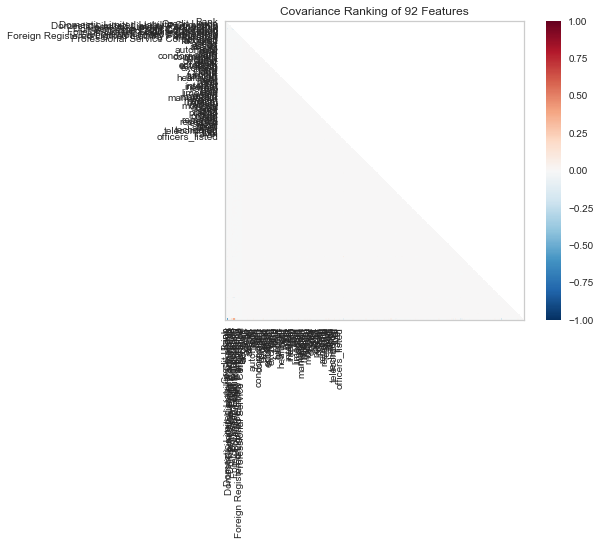

In [112]:
# We're down to 91 significant variables, an adjusted R^2 that's in the right ballpark, but we still have an 
# enormous condition number. 91 is too many variables to use tools like covariance rankings.

from yellowbrick.features import Rank2D

visualizer = Rank2D(features=vars_to_keep, algorithm='covariance')

visualizer.fit(smaller_X_train_manual, y_train_manual)
visualizer.transform(X_train_manual.astype(float))
visualizer.poof()

### Filtering from everything to a few variables doesn't seem like the right approach anymore. Let's do the opposite.

In [118]:
# What can we learn without any information from companies' names and descriptions?
base_variables = [dummy for dummy in entity_dummies.columns] + ['officers_listed']
base_variables.remove('Foreign Corporation')

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df[base_variables],
                                                    df['log_time_in_business'],
                                                    test_size=0.2,
                                                    random_state=5)

small_e_net = sm.OLS(y_train_base, X_train_base.astype(float), L1_wt=.5)
print(small_e_net.fit().summary())

                             OLS Regression Results                             
Dep. Variable:     log_time_in_business   R-squared:                       0.869
Model:                              OLS   Adj. R-squared:                  0.869
Method:                   Least Squares   F-statistic:                 1.230e+04
Date:                  Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                          18:41:48   Log-Likelihood:                -63612.
No. Observations:                 25964   AIC:                         1.273e+05
Df Residuals:                     25950   BIC:                         1.274e+05
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [136]:
# Proving that our 87% adjusted R^2 is meaningless:
e_net_cv_base = ElasticNetCV(cv=5)
e_net_cv_base.fit(X_train_base, y_train_base)
e_net_cv_base.score(X_test_base, y_test_base)

0.06609682062087685

### Dang. Lesson learned. I figured the multicolinearity was coming from all the names and descriptions, but it looks like a surprisingly large contributor is the legal organizational status of the companies.

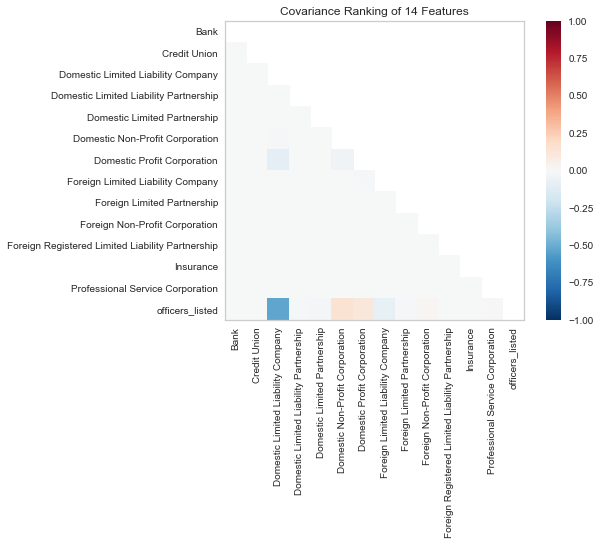

In [119]:
# Look for any unusually high covariances between variables
visualizer = Rank2D(features=base_variables, algorithm='covariance')

visualizer.fit(X_train_base, y_train_base)
visualizer.transform(X_train_base.astype(float))
visualizer.poof()

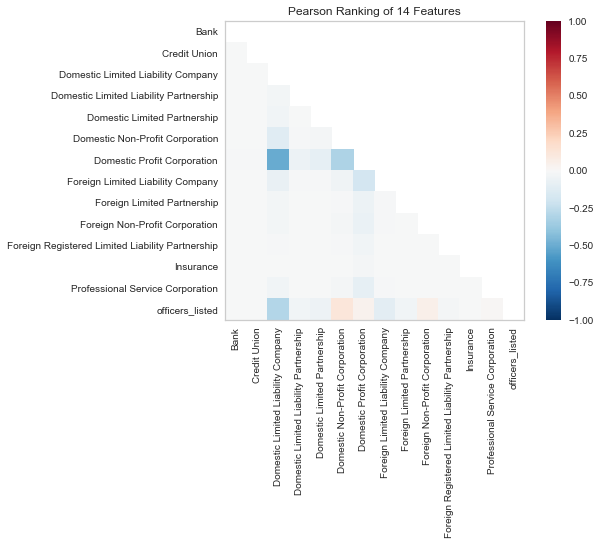

In [120]:
# That wasn't very useful. Give it another try:
visualizer = Rank2D(features=base_variables, algorithm='pearson')

visualizer.fit(X_train_base, y_train_base)
visualizer.transform(X_train_base.astype(float))
visualizer.poof()

### I can't decide how uncomfortable to feel about the non-normality test statistics. We knew that log(days_in_business) wasn't normally distributed, but it looked reasonably close. The kurtosis values in our ANOVA table of ~90 is really, really high.
### I'm going to abandon OLS and see if we have better luck with non-linear options.

In [134]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_base, y_train_base)
rf_model.get_params()

# Score the random forest two different ways, just cause.
print("Score:", rf_model.score(X_test_base, y_test_base))
print("CVS:", np.mean(cross_val_score(rf_model, X_train_base, y_train_base, cv=10)))

Score: 0.09576136224883791
CVS: 0.09867887668700376


c:\users\aubre\desktop\github_math\git_math\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarn

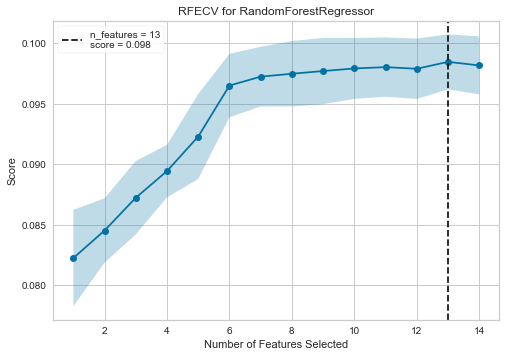

In [140]:
rf_model = RFECV(RandomForestRegressor(n_estimators=10))
rf_model.fit(X_train_base, y_train_base)
rf_model.poof()

In [148]:
# Diminishing returns hit hard after 6 variables. What are those 6?
from sklearn.feature_selection import RFE

estimator = RandomForestRegressor(n_estimators=10)
selector = RFE(estimator, 6, step=1)
selector = selector.fit(X_train_base, y_train_base)
selector.ranking_

print("Most important features:")
for item in range(len(selector.ranking_)):
    if selector.ranking_[item] == 1:
        print(X_train_base.columns[item])

print("")
print("Least important features:")
for item in range(len(selector.ranking_)):
    if selector.ranking_[item] != 1:
        print(X_train_base.columns[item])

Most important features:
Domestic Limited Liability Partnership
Domestic Limited Partnership
Domestic Non-Profit Corporation
Domestic Profit Corporation
Professional Service Corporation
officers_listed

Least important features:
Bank
Credit Union
Domestic Limited Liability Company
Foreign Limited Liability Company
Foreign Limited Partnership
Foreign Non-Profit Corporation
Foreign Registered Limited Liability Partnership
Insurance


In [ ]:
# The distinction here might be the number of entities registered as each entity type.
# Banks have significantly longer lives than average, but there aren't many of them.
### Check this out

# This is far from a completed study. 

### Things left to do:
    - There's a colinearity problem introduced by having separate variables for keywords in both EntityName and Comments: lots of companies with names like ABC Insurance will also say in their description that they sell insurance. Instead, the keyword variables should apply to both EntityName and Comments.
    - Similarly, I should figure out some clever way to make different variables for all words in EntityName & Comments that's present more than X amount of times. This whole inspect-by-hand thing isn't scalable and leaves too much room for my own biases in what names are important.
    - Inspect the error terms. Because log(time_in_business) isn't normally distributed, and the exceptions seem to be around the tails of the distribution, I bet the error term isn't fully independent.
    - Assess the impact of our data being censored (companies that are still in business aren't included in the analysis, which biases our results towards earlier deaths)
    - Not all of these businesses failed. Some were sold, merged, etc. An example is this: http://ucc.state.ri.us/CorpWeb/CorpSearch/CorpSummary.aspx?FEIN=000001992. The issue is figuring out the structure of the pages scraped to know how to scrape it.
    - Some of the data we used is subject to change over a company's lifetime. Addresses, DBAs, or the number of directors & officers can all change. Rhode Island includes lots of other documents, and it'd be great to see what other data we can get from those.
    - Overlay census data based on companies' principal addresses to see how population density or nearby wealth impact their life expectancy
    - Use our other variables like stock information, NAICS codes, or which foreign entities use registered agents
    - Consider macroeconomic factors: GDP growth, unemployment rates, etc
    - Test for unit roots: are there trends over time that we need to account for? Are survival rates different for companies founded in 1900 vs 1980? Do survival rates for different industruies, like technology or construction companies, change significantly over time due to structural changes (not due to macroeconomic factors that we can control for)?
    - More data is always better. I only used 10,000 samples in this study.
### An extension of this study:
    - It's neat to be able to estimate a company's lifespan at birth. It'd be useful to estimate how much longer a company will stay in business, regardless of how old it already is.

In [ ]:
# If you've done much scraping, then your failed_records list could be pretty long. You don't want to
# repeat attempting to scrape those failed records, so save the list to a file.

#with open('failed_records', 'wb') as fp:
#    pickle.dump(failed_records, fp)